In [20]:
import numpy as np
import matplotlib.pyplot as plt
from math import log2
from scipy.sparse import dok_matrix, csr_matrix, diags
from scipy.sparse.linalg import expm as sparse_expm
import mdptoolbox.mdp as mdp

In [21]:
N_pop         = 10000
mutation_rate = 0.001   # per Hamming-1 edge (discrete-time U)
tau           = 2000
dt            = 1
t_step        = int(tau/dt)
t             = np.linspace(0, tau, t_step+1)

num_genotypes = 8               # M = 8 -> dim(u) = 7
assert (log2(num_genotypes)).is_integer()
B = int(log2(num_genotypes))    # number of bits

# ------------- Fitness / actions -------------
actions = [0, 1, 2, 3]
drug_names = ['A','B','C','D']

drug_lists = {
    0: [0.993, 0.998, 1.009, 1.003, 1.007, 1.001, 0.992, 0.997],  # Drug A
    1: [0.995, 1.005, 1.002, 0.999, 1.005, 0.994, 0.999, 1.001],  # Drug B
    2: [0.997, 1.001, 0.989, 1.003, 1.003, 0.998, 1.010, 0.997],  # Drug C
    3: [1.005, 0.988, 0.999, 1.001, 0.995, 1.011, 1.000, 0.999]   # Drug D
}

In [22]:
def get_f(action):
    f = np.asarray(drug_lists[action], float)
    assert len(f) == num_genotypes
    return f

def get_s_vec(action):
    """Relative selection s_i = f_i/f_0 - 1 for i=1..M-1 (return length M-1)."""
    f = get_f(action)
    return f[1:] / f[0] - 1.0

def genotype_bitstrings(M):
    B = int(log2(M))
    return [format(i, f'0{B}b') for i in range(M)]

genotypes = genotype_bitstrings(num_genotypes)

In [23]:
# ------------- Discrete-time Hamming-1 mutation matrix U -------------
def build_hamming_U(M, mu):
    bits = genotype_bitstrings(M)
    U = np.zeros((M, M), float)
    for i in range(M):
        for j in range(M):
            if i != j:
                if sum(a != b for a,b in zip(bits[i], bits[j])) == 1:
                    U[i, j] = mu
    np.fill_diagonal(U, 1.0 - U.sum(axis=1))
    return U

U_ham = build_hamming_U(num_genotypes, mutation_rate)
Mmat  = U_ham - np.eye(num_genotypes)   # per-generation drift in x-space

In [24]:
# ------------- Coordinate transformation -------------
def x_from_u(u):
    """u (len M-1) -> x (len M) via stick breaking."""
    u = np.asarray(u, float)
    M = u.size + 1
    x = np.zeros(M, float)
    S = 1.0
    for k in range(1, M):
        uk  = u[k-1]
        x[k] = uk * S
        S   *= (1.0 - uk)
    x[0] = S
    return x

def S_prefix(u):
    """S_k = prod_{j<k} (1-u_j), returned as array over k=1..M-1 but 0-based aligned:
       S_u[i] = S_{k=i+1}. So S_u[0]=1, S_u[1]=(1-u1), ..."""
    u = np.asarray(u, float)
    d = u.size
    S = np.ones(d, float)
    prod = 1.0
    for i in range(d):
        S[i] = prod
        prod *= (1.0 - u[i])
    return S

def pack_from_x(x):
    """x (len M) -> u (len M-1)."""
    x = np.asarray(x, float)
    M = x.size
    u = np.zeros(M-1, float)
    cum = 0.0
    for i in range(1, M):
        denom = 1.0 - cum
        u[i-1] = 0.0 if denom <= 0 else x[i] / denom
        cum += x[i]
    return u

# ------------- Drift (mutation + selection) in u-space -------------
def drift_u_mut(u):
    """A^(mut)(u) from Mmat x(u)."""
    u = np.asarray(u, float)
    d = u.size
    x = x_from_u(u)
    Ax = Mmat @ x  # length M
    # prefix sums of Ax over indices i=1..M-1 (map to u indices 0..d-1)
    pref = np.concatenate([[0.0], np.cumsum(Ax[1:])])  # length d+1
    S = S_prefix(u)
    A = np.zeros(d, float)
    for k in range(d):  # u-index k ↔ x-index k+1
        Akx = Ax[k+1]
        sum_prev = pref[k]  # sum_{i=1}^{k} Ax[i]  (i<k+1)
        A[k] = (Akx + u[k]*sum_prev) / S[k]
    return A

def drift_u_sel(u, action):
    """A^(sel)(u) using compact tail-sum form."""
    u = np.asarray(u, float)
    d = u.size
    s = get_s_vec(action)   # length d, s[0] ↔ genotype 1
    x = x_from_u(u)
    S = S_prefix(u)
    # tail sums T_k = sum_{j=k}^{d-1} x_{j+1} s_j
    tail = np.zeros(d+1, float)
    for k in range(d-1, -1, -1):
        tail[k] = tail[k+1] + x[k+1]*s[k]
    A = np.zeros(d, float)
    for k in range(d):
        A[k] = (u[k]/S[k]) * (S[k]*s[k] - tail[k])
    return A

def drift_u(u, action):
    return drift_u_mut(u) + drift_u_sel(u, action)

def diffusion_u(u):
    """Diagonal diffusion D_k(u) = u_k(1-u_k)/(2N * S_k)."""
    u = np.asarray(u, float)
    S = S_prefix(u)
    return u * (1.0 - u) / (2.0 * N_pop * S)

# ------------- L^d Grid in u-space (MDP) -------------
L = 3
a = 1.0 / L
d = num_genotypes - 1       # dimension of u
N_states = L**d

# grid centers for each axis: 0.5*a, 1.5*a, ..., (L-0.5)*a
centers = a * (0.5 + np.arange(L))

# Enumerate states in lexicographic order i0 + L*i1 + ... + L^{d-1}*id-1
def index_to_multi(n, L, d):
    idx = np.empty(d, int)
    for r in range(d):
        idx[r] = (n // (L**r)) % L
    return idx

def multi_to_index(idx, L):
    n = 0
    for r, ir in enumerate(idx):
        n += (L**r)*ir
    return n

states = []
for n in range(N_states):
    idx = index_to_multi(n, L, d)
    u = centers[idx]
    states.append(u)

# ------------- Transition rate matrix Ω -------------
def build_transition_rate_matrix(action, states):
    Omega = dok_matrix((N_states, N_states), dtype=np.float64)
    strides = [L**r for r in range(d)]

    for n in range(N_states):
        u = states[n]                         # vector length d
        A = drift_u(u, action)                # length d
        D = diffusion_u(u)                    # length d
        idx = index_to_multi(n, L, d)

        for r in range(d):
            # forward neighbor along axis r
            if idx[r] < L-1:
                m = n + strides[r]
                rate = D[r]/a**2 + A[r]/(2*a)
                Omega[n, m] = rate
            # backward neighbor along axis r
            if idx[r] > 0:
                m = n - strides[r]
                rate = D[r]/a**2 - A[r]/(2*a)
                Omega[n, m] = rate

    # diagonals: rows sum to zero
    for n in range(N_states):
        row_sum = Omega[n, :].sum()
        Omega[n, n] = -row_sum
    return Omega.tocsr()

def build_transition_matrix_sparse(Omega, dt):
    """
    Input:  Omega as CSR (generator of a CTMC), dt scalar.
    Output: W as CSR, row-stochastic transition matrix at step dt.
    """
    # matrix exponential in sparse
    W = sparse_expm(Omega * dt)            # returns a sparse CSC/CSR
    W = W.tocsr()

    # clip tiny negative entries from expm numerical noise
    if W.nnz:
        data = W.data
        data[data < 0] = 0.0
        W.data = data

    # row-normalize in sparse
    row_sums = np.asarray(W.sum(axis=1)).ravel()
    # avoid divide-by-zero (isolated rows shouldn't happen, but be safe)
    row_sums[row_sums == 0] = 1.0
    Dinv = diags(1.0 / row_sums)
    W = Dinv @ W
    return W.tocsr()

# ------------- Reward (- mean fitness) -------------
def compute_reward(u_state, action):
    x = x_from_u(u_state)
    return -x.dot(get_f(action))

def build_W_and_R(actions, states, dt):
    # Vectorize reward computation to avoid Python loops
    S = np.array(states)                    # shape (N_states, d)
    # Turn states (u) into x for all states in one pass
    # (x_from_u is fast; we’ll just loop in NumPy, which is fine for ~2k states)
    X = np.vstack([x_from_u(u) for u in S]) # shape (N_states, M)

    P = []
    R = np.zeros((N_states, len(actions)), dtype=float)

    for a in actions:
        # build sparse generator Ω(a)
        Omega = build_transition_rate_matrix(a, states)   # already returns CSR
        # sparse expm + normalize
        W = build_transition_matrix_sparse(Omega, dt)     # CSR
        P.append(W)

        # reward: - mean fitness under action a
        f = get_f(a)                                      # length M
        R[:, a] = -X.dot(f)
    return P, R

# Build MDP and solve by Value Iteration
P, R = build_W_and_R(actions, states, dt)

In [ ]:
vi = mdp.ValueIteration(transitions=P, reward=R,
                        discount=0.99, epsilon=1e-4, max_iter=1000)
vi.run()

policy_flat = np.array(vi.policy, int)

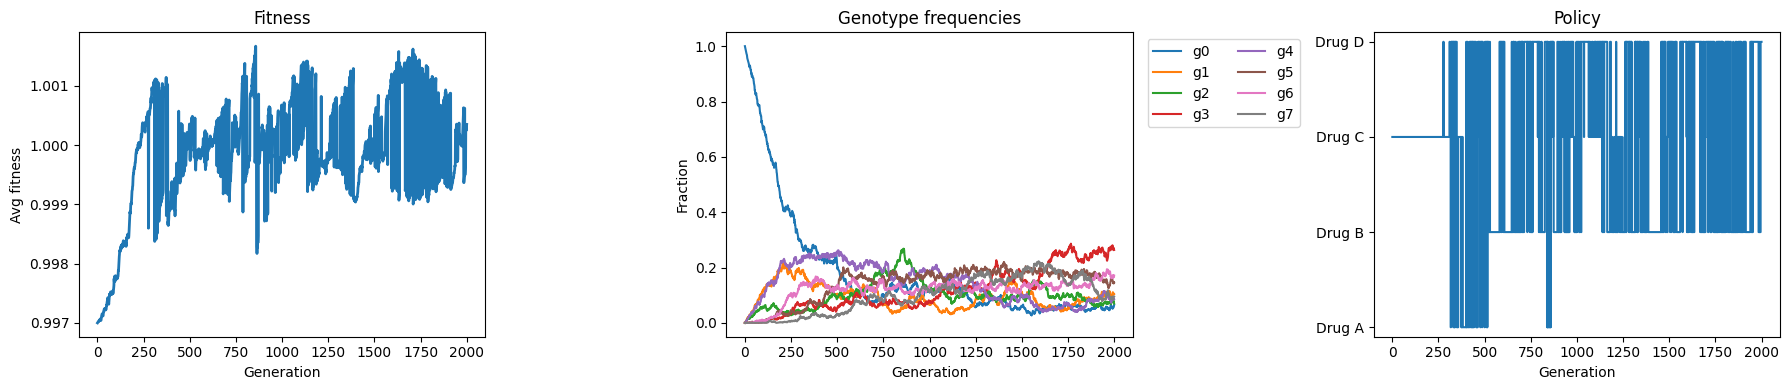

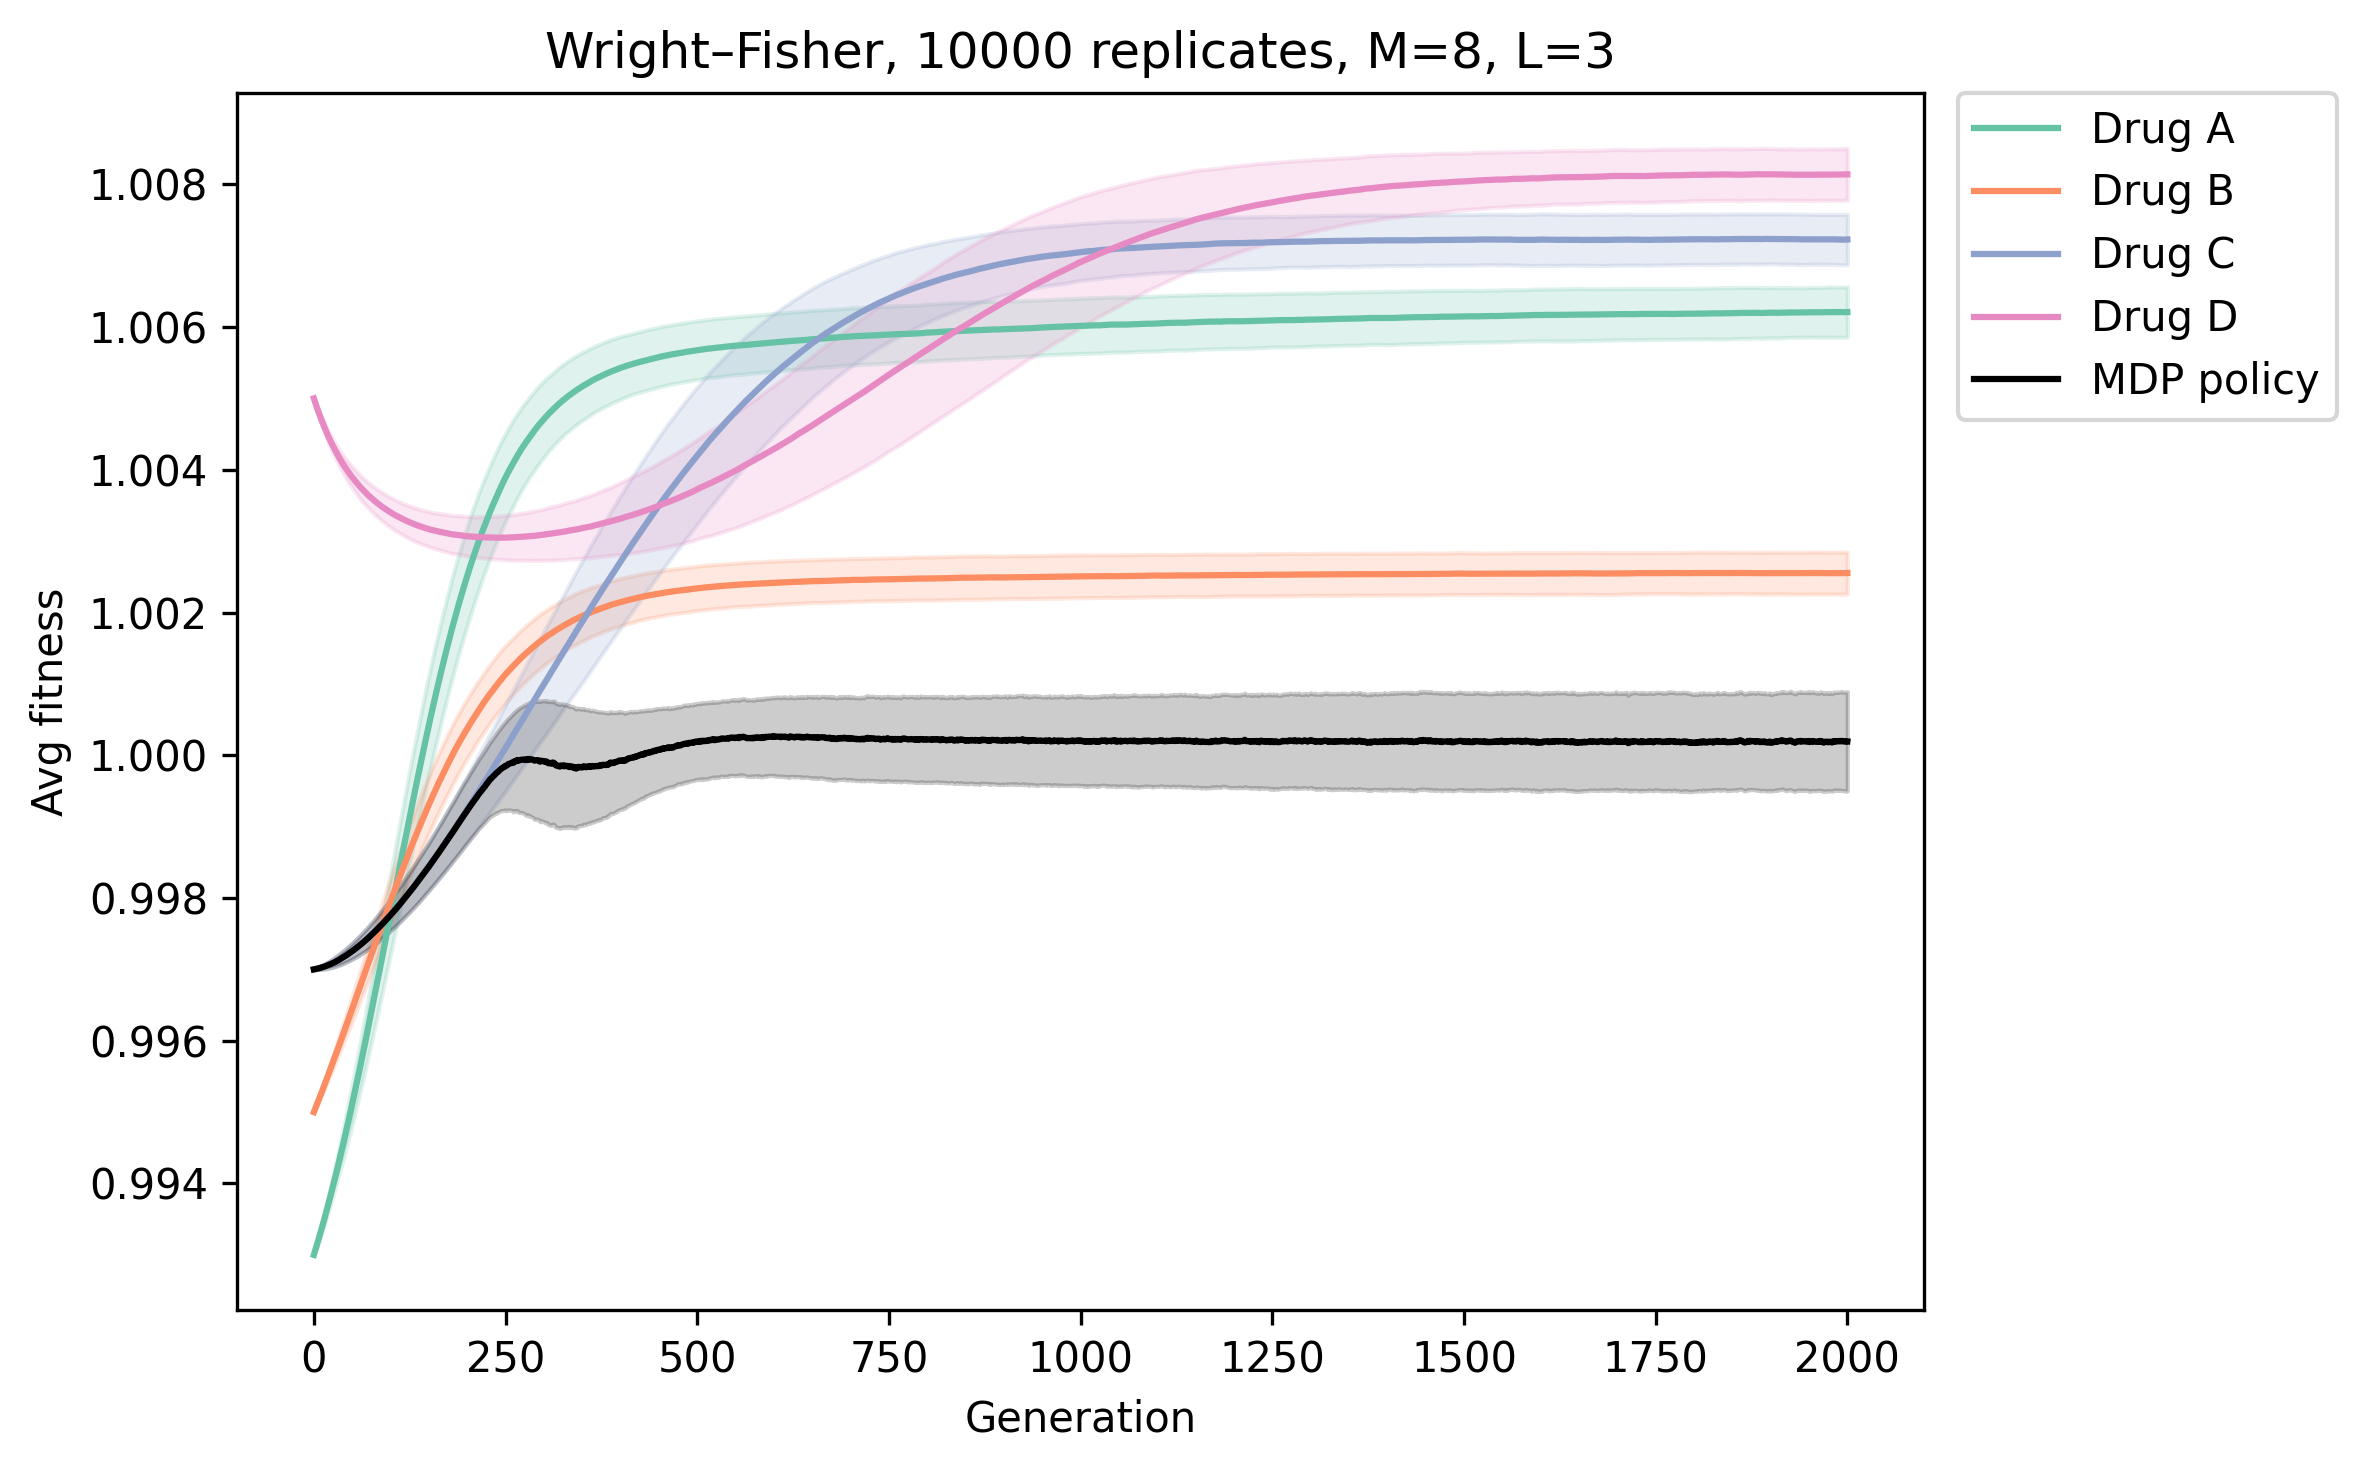

In [ ]:
# ------------- Map continuous freq -> grid index for policy -------------
def freq_to_state_idx(freq):
    u = pack_from_x(freq)                      # length d
    # bin each coordinate to 0..L-1
    idx = np.minimum((u * L).astype(int), L-1)
    return multi_to_index(idx, L)

def mdp_picker(freq):
    return int(policy_flat[freq_to_state_idx(freq)])

# ------------- Wright–Fisher simulator using MDP policy -------------
def run_wf(picker):
    counts = np.zeros(num_genotypes, int); counts[0] = N_pop
    freq   = counts / N_pop

    fit_traj    = np.zeros(t_step+1)
    freq_traj   = np.zeros((t_step+1, num_genotypes))
    action_traj = np.zeros(t_step+1, int)

    a0 = picker(freq)
    f0 = get_f(a0)
    fit_traj[0]   = freq.dot(f0)
    freq_traj[0]  = freq
    action_traj[0]= a0

    for gen in range(1, t_step+1):
        a     = picker(freq)
        f_vec = get_f(a)
        # selection
        w_bar    = freq.dot(f_vec)
        freq_sel = (freq * f_vec) / w_bar
        # mutation (discrete-time)
        freq_mut = U_ham.T @ freq_sel
        # drift
        counts = np.random.multinomial(N_pop, freq_mut)
        freq   = counts / N_pop

        fit_traj[gen]    = freq.dot(f_vec)
        freq_traj[gen]   = freq
        action_traj[gen] = a

    return fit_traj, freq_traj, action_traj


# ------- Single run -------
fitness1, freqs1, actions1 = run_wf(mdp_picker)

fig, axs = plt.subplots(1,3, figsize=(18,4))
axs[0].plot(t, fitness1, lw=2)
axs[0].set(title="Fitness", xlabel="Generation", ylabel="Avg fitness")

for g in range(num_genotypes):
    axs[1].plot(t, freqs1[:, g], label=f"g{g}")
axs[1].legend(ncol=2, bbox_to_anchor=(1.02,1), loc="upper left")
axs[1].set(title="Genotype frequencies", xlabel="Generation", ylabel="Fraction")

axs[2].step(t, actions1, where='post')
axs[2].set(yticks=actions, yticklabels=[f"Drug {n}" for n in drug_names],
           title="Policy", xlabel="Generation")
axs[2].set_ylim(-0.1, max(actions)+0.1)

plt.tight_layout(); plt.show()

# ------- Replicates & comparison to single-drug -------
n_reps = 10000
all_fit = np.zeros((len(actions)+1, n_reps, t_step+1))

# single-drug baselines
for d_idx, drug in enumerate(actions):
    const_picker = (lambda freq, a=drug: a)
    for r in range(n_reps):
        all_fit[d_idx, r], _, _ = run_wf(const_picker)

# MDP policy
for r in range(n_reps):
    all_fit[-1, r], _, _ = run_wf(mdp_picker)

mean_fit = all_fit.mean(axis=1)
std_fit  = all_fit.std(axis=1)

plt.figure(figsize=(8,5), dpi=300)
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','black']
labels = [f"Drug {n}" for n in drug_names] + ["MDP policy"]

for i in range(len(actions)+1):
    plt.plot(t, mean_fit[i], color=colors[i], label=labels[i])
    plt.fill_between(t, mean_fit[i]-std_fit[i], mean_fit[i]+std_fit[i],
                     color=colors[i], alpha=0.2)

plt.xlabel("Generation"); plt.ylabel("Avg fitness")
plt.legend(loc='upper left', bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.title(f"Wright–Fisher, {n_reps} replicates, M={num_genotypes}, L={L}")
plt.tight_layout(); plt.show()


Global min: 0.988 Global max: 1.011


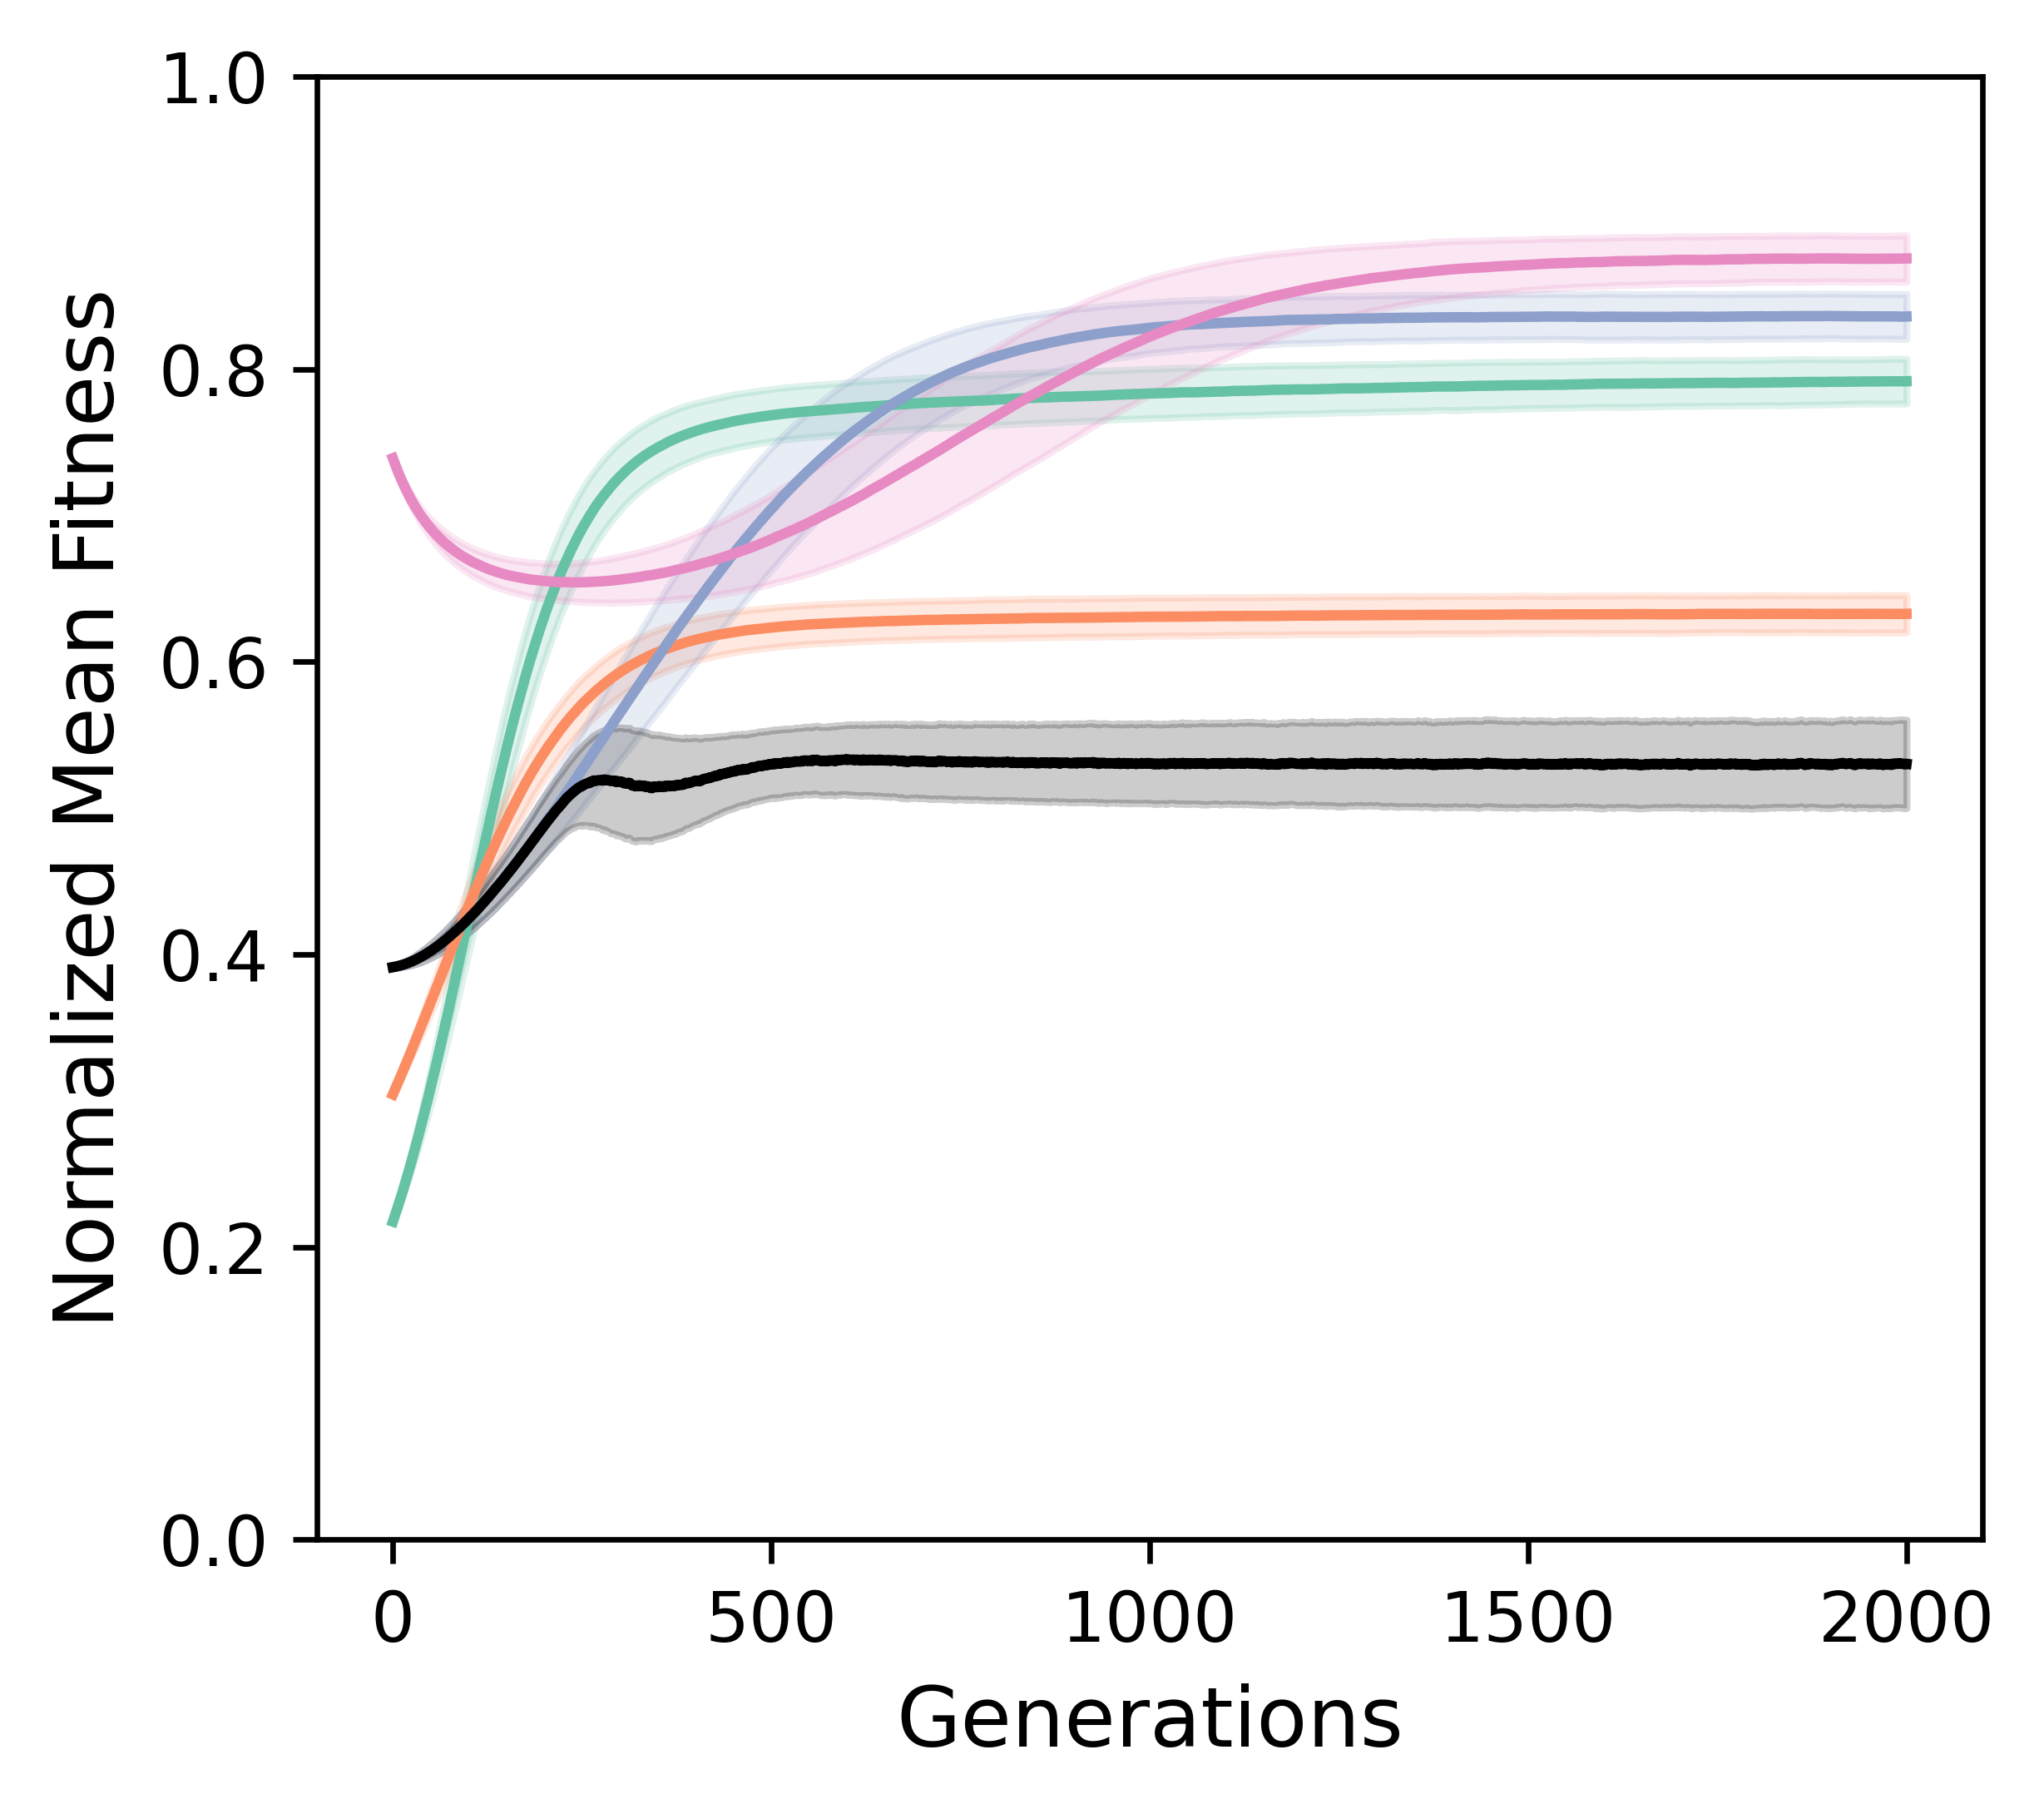

In [ ]:
# collect all fitness values
all_fits = np.concatenate(list(map(np.array, drug_lists.values())))
global_min = all_fits.min()
global_max = all_fits.max()
print("Global min:", global_min, "Global max:", global_max)

# normalize mean_fit and std_fit by min-max scaling
mean_fit_norm = (mean_fit - global_min) / (global_max - global_min)
std_fit_norm  = std_fit / (global_max - global_min)   # scale std by same denominator

# --- plot ---
plt.figure(figsize=(4.2, 4/4.5*4.2), dpi=600)
#plt.figure(figsize=(6,4), dpi=600)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 'black']
labels = [f"Drug {n}" for n in drug_names] + ["MDP"]

for i in range(len(actions)+1):
    m = mean_fit_norm[i]
    s = std_fit_norm[i]
    plt.plot(t, m, color=colors[i], label=labels[i])
    plt.ylim(0,1)
    plt.fill_between(t, m - s, m + s, color=colors[i], alpha=0.2)

plt.xlabel("Generations", fontsize=12)
plt.ylabel("Normalized Mean Fitness", fontsize=12)
#plt.title(f"Wright–Fisher {n_reps} Replicates (min–max normalized)")
#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()


In [ ]:
import itertools

# ---------- ordered pairs (A→B and B→A are distinct) ----------
pairs = list(itertools.combinations(actions, 2))   # len = 6 for 4 drugs
pair_labels = [f"Drug {drug_names[a]}↔{drug_names[b]}" for a, b in pairs]

# ---------- alternating picker (no change to run_wf) ----------
def make_alt_picker_first(a, b, block_len=1):
    """Return picker(freq) that yields A→B→A→B… in blocks of length `block_len`."""
    counter = {'i': 0}
    def picker(_freq, a=a, b=b, block_len=block_len):
        blk = counter['i'] // block_len
        counter['i'] += 1
        return a if (blk % 2 == 0) else b
    return picker

# ---------- run the 6 A↔B policies ----------
n_pairs = len(pairs)
all_fit_two = np.zeros((n_pairs + 1, n_reps, t_step + 1))  # extra row for MDP

for p_idx, (a, b) in enumerate(pairs):
    for r in range(n_reps):
        # fresh picker per replicate to avoid counter leakage
        alt_picker = make_alt_picker_first(a, b, block_len=1)  # set block_len>1 for A…A B…B
        all_fit_two[p_idx, r], _, _ = run_wf(alt_picker)

In [ ]:
from matplotlib.colors import to_rgb, to_hex

# --- helpers for pair colors (gamma-corrected blend) ---
single_color = {'A':'#66c2a5','B':'#fc8d62','C':'#8da0cb','D':'#e78ac3'}

def blend_hex(c1, c2, w=0.5, gamma=2.2):
    r1,g1,b1 = to_rgb(c1); r2,g2,b2 = to_rgb(c2)
    r1,g1,b1 = r1**gamma, g1**gamma, b1**gamma
    r2,g2,b2 = r2**gamma, g2**gamma, b2**gamma
    rl = (1-w)*r1 + w*r2; gl = (1-w)*g1 + w*g2; bl = (1-w)*b1 + w*b2
    return to_hex((rl**(1/gamma), gl**(1/gamma), bl**(1/gamma)))

def color_for_pair(a_idx, b_idx, w=0.5):
    na, nb = drug_names[a_idx], drug_names[b_idx]  # e.g., 'A','B'
    return blend_hex(single_color[na], single_color[nb], w=w)

# Build colors to match your `pairs` and `pair_labels`
pair_colors = [color_for_pair(a, b, w=0.5) for (a, b) in pairs]   # 6 colors


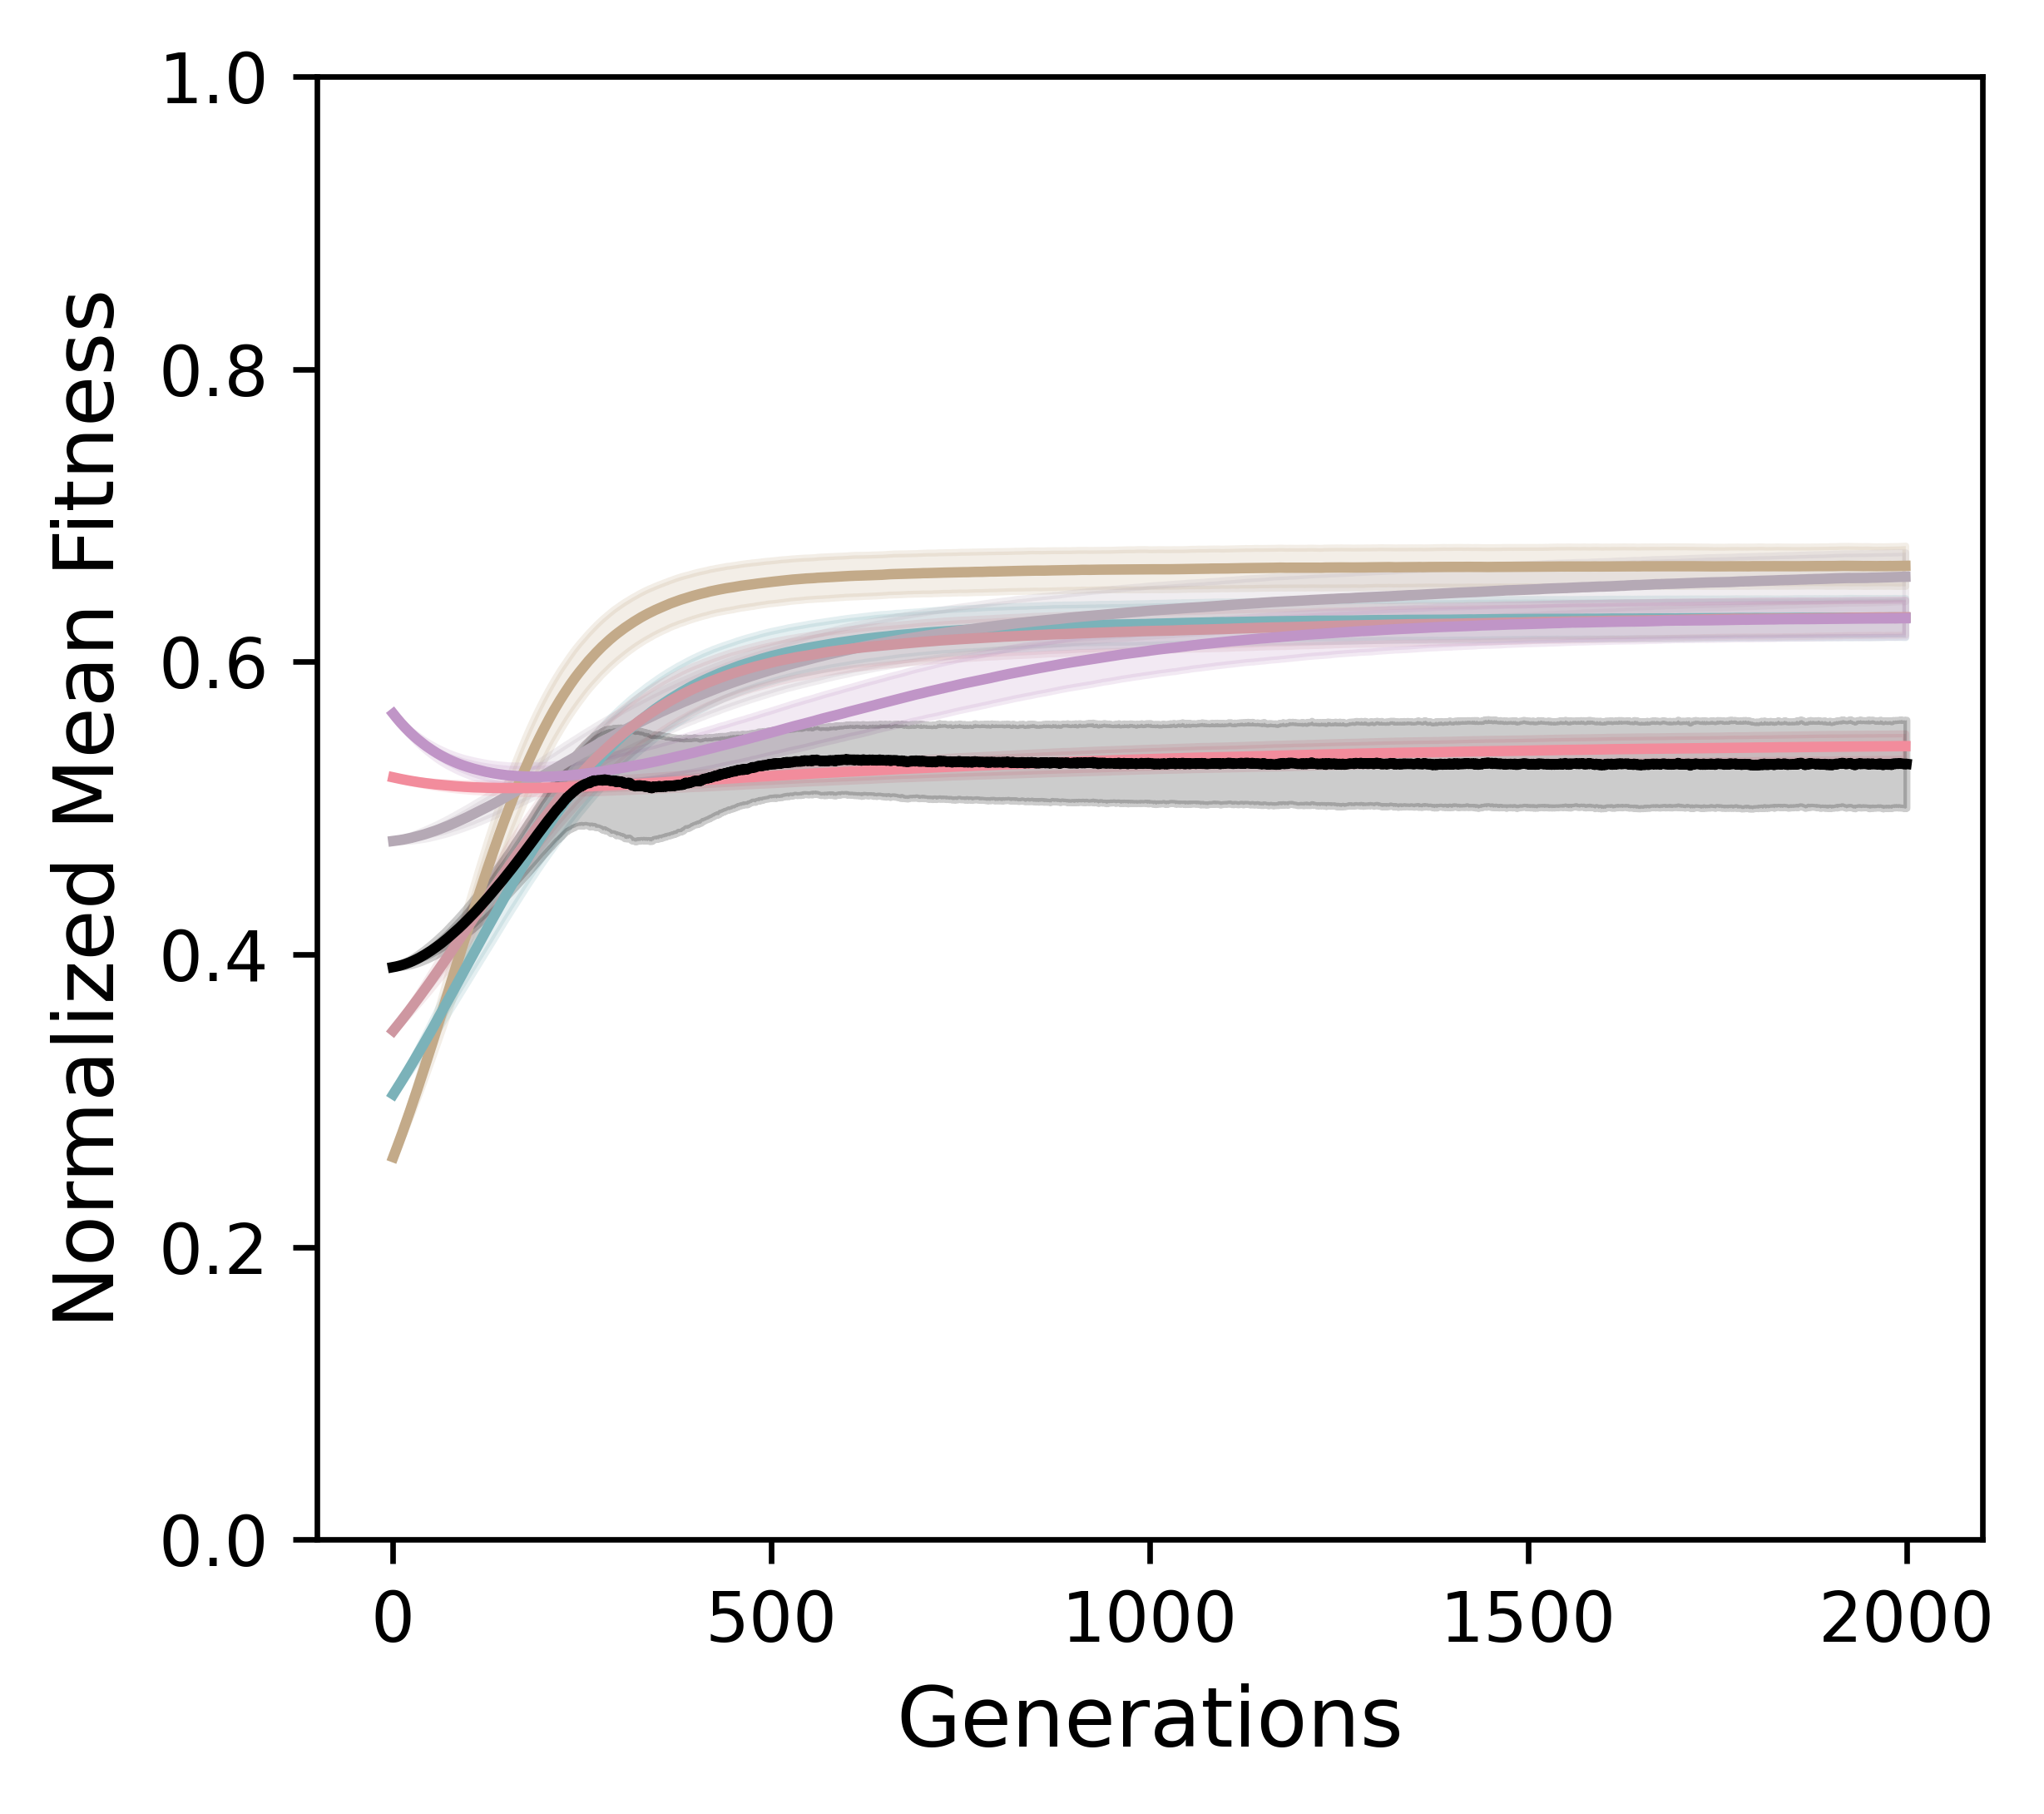

In [ ]:
# all_fit_two: (n_pairs+1, n_reps, T); last row = MDP copied from all_fit[-1]
P, R, T = all_fit_two.shape
n_pairs = P - 1
T_even  = (T // 2) * 2

# --- 2-gen average ONLY for the pairs (exclude the last MDP row) ---
two_cycle = all_fit_two[:n_pairs, :, :T_even].reshape(n_pairs, R, T_even//2, 2).mean(axis=3)
mean_pairs = two_cycle.mean(axis=1)               # (n_pairs, T_even/2)
std_pairs  = two_cycle.std(axis=1)                # (n_pairs, T_even/2)

# --- MDP stays per-generation (no 2-gen averaging) ---
mdp_mean = mean_fit_norm[-1]
mdp_std  = std_fit_norm[-1]

# --- normalize everything with your existing global_min/global_max ---
den = max(global_max - global_min, 1e-12)
mean_pairs_norm = (mean_pairs - global_min) / den
std_pairs_norm  =  std_pairs / den

# --- time axes: pairs use 2-gen midpoints; MDP uses original t ---
t2 = t[:T_even].reshape(-1, 2).mean(axis=1)       # (T_even/2,)

# ===== plot: pairs (2-gen averaged) vs MDP (original) =====
#tab = plt.cm.tab20.colors

plt.figure(figsize=(4.2, 4/4.5*4.2), dpi=600)
#plt.figure(figsize=(6,4), dpi=600)

# pairs
for i in range(n_pairs):
    m, s = mean_pairs_norm[i], std_pairs_norm[i]
    col  = pair_colors[i]
    plt.plot(t2, m, color=col, label=pair_labels[i])
    # comment next line if you want means only:
    plt.fill_between(t2, m - s, m + s, color=col, alpha=0.2)

# MDP (no averaging)
plt.plot(t, mdp_mean, color="black", label="MDP")
# comment next line if you want means only:
plt.fill_between(t, mdp_mean - mdp_std, mdp_mean + mdp_std,
                 color="black", alpha=0.2)

plt.xlabel("Generations", fontsize=12)
plt.ylabel("Normalized Mean Fitness", fontsize=12)
plt.ylim(0, 1)
#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)
plt.tight_layout()
plt.show()
